In [1]:
import torch as t
from torch.nn.functional import normalize
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
import torch.utils.data as D
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt 

## Dataset preparations

In [2]:
screen_size = 1000
def make_windowed_data():
    dataset = t.load("data/ffa_channelpark.pt", weights_only=False)
    observations, rewards = dataset.tensors
    positions = observations[:,:2].float()
    angles = observations[:,2].float()
    commands = observations[:,3:].float()
    angles *=  10  * t.pi / 180
    angles = t.stack([t.cos(angles), t.sin(angles)], dim=1)
    positions*=screen_size


    
    windowed = positions.unfold(dimension=0, size=10, step=1)  # (b, 2, 10)
    windowed_rewards = rewards.unfold(dimension=0,size=10, step=1) # (b, 10)
    windowed_angles = angles.unfold(dimension=0,size=10, step=1) # (b, 10)
    windowed_commands = commands.unfold(dimension=0,size=10, step=1) # (b,2, 10)
    mask = windowed_rewards.pow(2).sum(-1) == 0
    good_windows = windowed[mask]
    good_angles = windowed_angles[mask]
    x_angles = good_angles[:,:,-2]
    y_angles = good_angles[:,:,-1]
    x_commands = windowed_commands[mask][:,:,-2]

    diffs = good_windows.diff(dim=-1)
    x = diffs[:, :, :-1]
    y = diffs[:, :, -1]

    print(f'Shape of good_windows:\t{good_windows.shape}')
    print(f'Shape of x:\t{x.shape}')
    print(f'Shape of y:\t{y.shape}')
    print(f'Shape of x_angles:\t{x_angles.shape}')
    print(f'Shape of y_angles:\t{y_angles.shape}')
    print(f'Shape of x_commands:\t{x_commands.shape}')
    return good_windows,x, y,x_angles,y_angles, x_commands
    
w,x, y,x_angles,y_angles,x_commands = make_windowed_data()
X=x.flatten(start_dim=1, end_dim=-1)
print(f'Shape of X:\t{X.shape}')
t.linalg.cond(X)


Shape of good_windows:	torch.Size([2322620, 2, 10])
Shape of x:	torch.Size([2322620, 2, 8])
Shape of y:	torch.Size([2322620, 2])
Shape of x_angles:	torch.Size([2322620, 2])
Shape of y_angles:	torch.Size([2322620, 2])
Shape of x_commands:	torch.Size([2322620, 2])
Shape of X:	torch.Size([2322620, 16])


tensor(112.8253)

## 

## Constant model

In [3]:
mse  = mean_squared_error(0 * X.reshape(-1, 2, 8)[:, :, -1], y)
print("Constant model error:\t",mse)
mse  = mean_squared_error(X.reshape(-1, 2, 8)[:, :, -1], y)
print("Baseline error:\t",mse)

Constant model error:	 7.744957480923398
Baseline error:	 0.2046320093630694


##  Linear Regression

In [9]:
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
mse  = mean_squared_error(y, y_pred)
print("Mean squared error:\t",mse)

Mean squared error:	 3.4720349311828613


## Torch's linear layer

In [5]:
def run_sgd_batched(X, y, lr, batch=1024, epochs=3):
    dataset = TensorDataset(X, y)
    train_loader = D.DataLoader(dataset, batch_size=batch, shuffle=False)
    model = t.nn.Linear(X.shape[1], y.shape[1]).to(t.float32)
    opt = t.optim.SGD(lr=lr, params=model.parameters())
    loss_fn = t.nn.MSELoss()
    for j in range(epochs):
        for i, (b_x, b_y) in enumerate(train_loader):
          train_loss = loss_fn(b_y, model(b_x))
          opt.zero_grad()
          train_loss.backward()
          opt.step()
        print(f'Train loss for epoch {j}:\t{train_loss}')
    return model
      

In [8]:
model =run_sgd_batched(X, y, 2e-3)

Train loss for epoch 0:	0.12936235964298248
Train loss for epoch 1:	0.11680002510547638
Train loss for epoch 2:	0.11530094593763351


## Trajectories
### Linear regresssion model

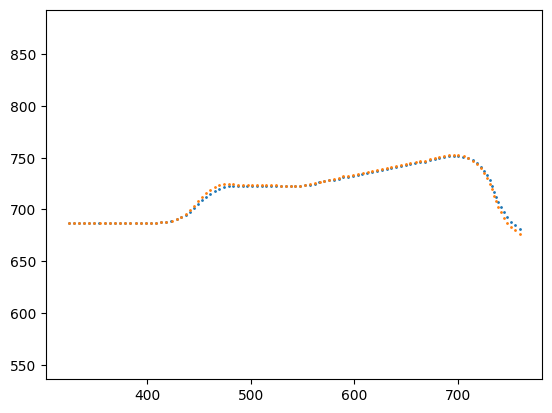

In [10]:
y_pred = reg.predict(X)
diff_pred = t.tensor(y_pred) + w[:,:,-2]
steps = 100
start = 1000
end = start+steps
#plt.xlim((0, screen_size)) 
#plt.ylim((0, screen_size)) 
plt.axis('equal')
plt.scatter(w[start:end,0,-2],w[start:end,1,-2],s=1)
plt.scatter(diff_pred[start:end,0],diff_pred[start:end,1],s=1)
plt.show()


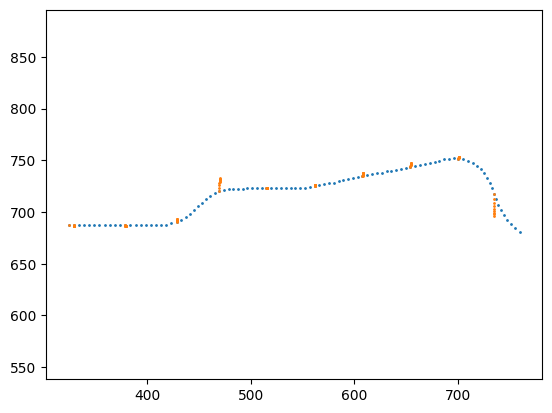

In [11]:

pos_pred = t.zeros((steps,2))
diff_pred = t.zeros((steps,16))

pos_pred[0] = w[start,:,-2]
diff_pred[0]=X[start]
for i in range(steps-1):
     y_pred = reg.predict(diff_pred[i].reshape(1, -1))
     y_pred = t.tensor(y_pred[0])
     diff_pred[i+1] = t.concat(
          (diff_pred[i][2:16], y_pred)
     )  
     pos_pred[i+1] = pos_pred[i] + y_pred
     if i % 10 ==0:
         pos_pred[i+1] = w[start+i+1,:,-2] 
         diff_pred[i+1] = X[start+i+1]

#plt.xlim((0, screen_size)) 
#plt.ylim((0, screen_size)) 
plt.axis('equal')
plt.scatter(w[start:end,0,-2],w[start:end,1,-2],s=1)
plt.scatter(pos_pred[:,0],pos_pred[:,1],s=1)
plt.show()

### Torch model

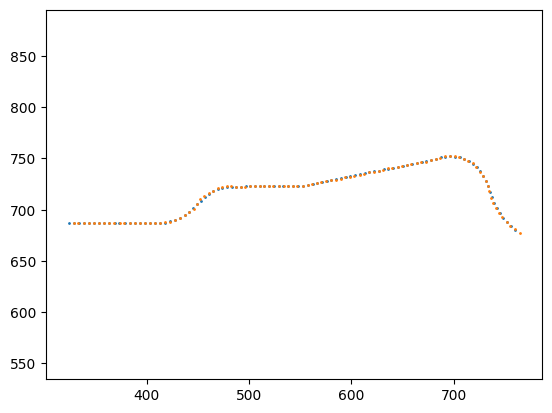

In [10]:
y_pred = model(X)
diff_pred = y_pred.detach() + w[:,:,-2]
#plt.xlim((0, screen_size)) 
#plt.ylim((0, screen_size)) 
plt.axis('equal')
plt.scatter(w[start:end,0,-2],w[start:end,1,-2],s=1)
plt.scatter(diff_pred[start:end,0],diff_pred[start:end,1],s=1)
plt.show()

## Try to include angles and commands to generate trajectories

In [11]:
new_X = t.concat((X,x_angles,x_commands),dim=1)
new_y = t.concat((y,y_angles),dim=1)
print(new_X.shape)
print(new_y.shape)

torch.Size([2322620, 20])
torch.Size([2322620, 4])


In [12]:

reg = LinearRegression().fit(new_X, new_y)
y_pred = reg.predict(new_X)
mse  = mean_squared_error(new_y, y_pred)
print("Mean squared error:\t",mse)

Mean squared error:	 1.7365370988845825


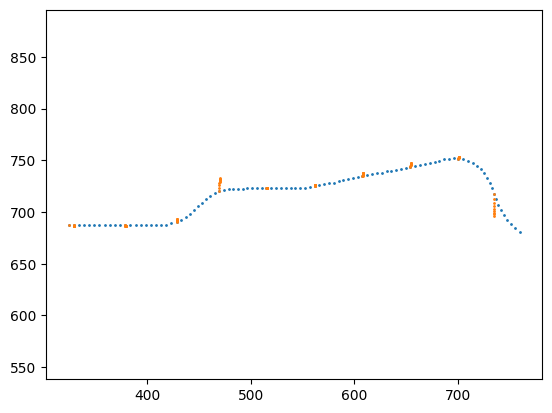

In [18]:

steps = 100
start = 1000
end = start+steps

pos_pred = t.zeros((steps,2))
diff_pred = t.zeros((steps,20))

pos_pred[0] = w[start,:,-2]
diff_pred[0]=new_X[start]
for i in range(steps-1):
     y_pred = reg.predict(diff_pred[i].reshape(1, -1))
     y_pred = t.tensor(y_pred[0])
     diff_pred[i+1] = t.concat(
          (diff_pred[i][2:16], y_pred, x_commands[start+1+i])
     )  
     pos_pred[i+1] = pos_pred[i] + y_pred[:2] 
     if i % 10 ==0:
         pos_pred[i+1] = w[start+i+1,:,-2] 
         diff_pred[i+1] = new_X[start+i+1]

#plt.xlim((0, screen_size)) 
#plt.ylim((0, screen_size)) 
plt.axis('equal')
plt.scatter(w[start:end,0,-2],w[start:end,1,-2],s=1)
plt.scatter(pos_pred[:,0],pos_pred[:,1],s=1)
plt.show()

In [15]:
model =run_sgd_batched(new_X, new_y, 5e-3,epochs=6)

Train loss for epoch 0:	0.07218308746814728
Train loss for epoch 1:	0.06202208623290062
Train loss for epoch 2:	0.05945154279470444
Train loss for epoch 3:	0.058209262788295746
Train loss for epoch 4:	0.05773770064115524
Train loss for epoch 5:	0.057512588798999786


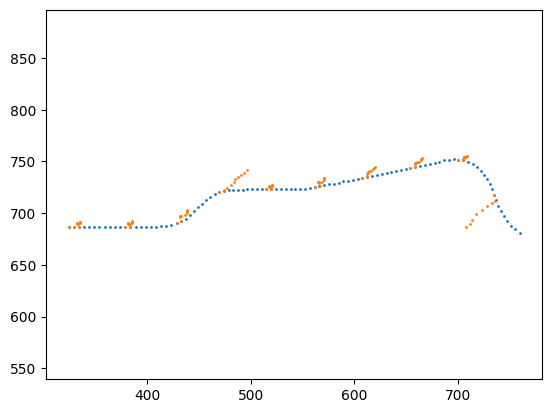

In [17]:

pos_pred = t.zeros((steps,2))
diff_pred = t.zeros((steps,20))

pos_pred[0] = w[start,:,-2]
diff_pred[0]=new_X[start]
for i in range(steps-1):
     y_pred = model(diff_pred[i])
     diff_pred[i+1] = t.concat(
          (diff_pred[i][2:16], y_pred, x_commands[start+1+i])
     )  
     pos_pred[i+1] = pos_pred[i] + y_pred[:2] 
     if i % 10 ==0:
         pos_pred[i+1] = w[start+i+1,:,-2] 
         diff_pred[i+1] = new_X[start+i+1]
pos_pred = pos_pred.detach()
#plt.xlim((0, screen_size)) 
#plt.ylim((0, screen_size)) 
plt.axis('equal')
plt.scatter(w[start:end,0,-2],w[start:end,1,-2],s=1)
plt.scatter(pos_pred[:,0],pos_pred[:,1],s=1)
plt.show()